# MPlot tutorial

The MPlot is used to check the distance between subsequence pairs into a time series according to a window size. This notebooks is a tutorial of how to use the different methods defined in mplots.ipyn for the specific case of 'insectParadoxus'.

## What is an MPlot?
MPlots were introduced by Eamonn Keogh and has a lot of research behind. The code in this notebook is mainly inspired in the XXVI paper:

- [IEEE - Matrix Profile XXVI: Mplots: Scaling Time Series Similarity Matrices to Massive Data](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10027730)

and following the guidelines of the example of use repository 

- [Zach Zimmerman - mplots-explorer (GitHub)](https://github.com/zpzim/mplot-explorer)

It also integrates methods of Stumpy:
- [Tutorial: The Matrix Profile](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html#Time-Series-with-Length-n-=-13)

Feel free of modifying the parameters and open issue in case of error!


**Note**

For the example in this notebook, the instructions in [Introducing Mplots: Scaling Time Series Recurrence Plots to Massive Datasets](https://web.archive.org/web/20240125145941id_/https://assets.researchsquare.com/files/rs-3651179/v1_covered_ef5f7e93-ace3-4376-b6f6-3021b43d586c.pdf?c=1701243102) have been followed. You can check more examples in [MPlots-pdf-Catalog](https://drive.google.com/file/d/1fjWUzVQf-8XmS5epDa_ulm4-bDX51Vxv/view). You will also find lots more datasets at his GoogleDrive. [This powerpoint](https://www.slideserve.com/mickie/ucr-time-series-semantic-segmentation-archive-powerpoint-ppt-presentation) explains the content of some of them in a simple way, including the insect Paradoxus dataset.

## Notebook configuration
### Parameters

The parameters in this notebook are only some of the input parameters you can define for the *06-Mplot* notebook. In that notebook the configuration parameters are included in the first cell and fully explained as needed. 

Here you got:

- `verbose`. If `>0` it adds debbuging messages in those functions that allows so.
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `check_memory_usage`. If `True`, it adds some lines for checking the GPU memmory ussage along the execution.
- `time_flag`. If `True` it get the execution time along the notebook as well as inside those functions that allows so.
- `cuda_device`. Integer used to define the GPU machine to be used for computation. Please ensure it is an id number valid for the built docker (check your .env file to know the valid ids)
- `execute_01`. Put this flag to true in case you have never executed the 01_<> notebook for the insectParadoxus dataset. Please change it to false one the celss in the section `Execute '1` have already been executed. It does not take very long, but it is some time ;).

In [1]:
#| export
# Configuration paramaters
verbose                       = 1
reset_kernel                  = False
check_memory_usage            = True
time_flag                     = True
cuda_device                   = 1
execute_01                    = False

In [2]:
print("--- Check parameters ---")
print(
    "verbose (for printing or not messages):", verbose, "\n",
    "check_memory_usage (for evaluating the current gpu memor status)", check_memory_usage, "\n",
    "time_flag:", time_flag, "\n",
    "reset_kernel:",reset_kernel, "\n",
    "cuda_device", cuda_device, "\n"
)

--- Check parameters ---
verbose (for printing or not messages): 1 
 check_memory_usage (for evaluating the current gpu memor status) True 
 time_flag: True 
 reset_kernel: False 
 cuda_device 1 



### VsCode update patch
Initial notebook setup when using VSCode.

In [3]:
#| export
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

## Import libraries

In [4]:
#| export
import warnings
warnings.filterwarnings("ignore", module="umap")
warnings.simplefilter('always', UserWarning)
import os
import sys
sys.path.append(os.path.abspath('..'))
import dvats.config as cfg_
import dvats.mplots as mplots
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb


Octave is ready <oct2py.core.Oct2Py object at 0x7f427afa00a0>

















## Execute 01 notebook
If you haven't executed the 01_<> notebook, execute the next 5 code cells

Please be sure that you have already downloaded the insectParadoxus dataset into your local path 
deepvats\..\data\ as .csv . You can check it with the next cell. It can be downloaded from [segData](https://drive.google.com/file/d/1mJs_FSjSnffw2xPJhu3SlES2kXSCMoNy/view). Unzip the folder and get the `insectParadoxusSP02_30_10000.txt` file and change the extension to `.csv` so you can execute the code. There are some utilities function if you can do it directly here in the `nbs\mplots.ipybn` notebook, but they are not relevant for this tutorial. If you want, just take a look and if you think it is usefull, make a pull requests with the changes to add here the downloading lines using those utilities functions. Thanks!

In [5]:
#-- For setting up the parameters
import os
import torch
from typing import Tuple, Dict

#-- Specific
from ploomber_engine import execute_notebook

##### Ensure the correct configuration for ploomber engine execution

In [6]:
def get_parameters(nb_id : int, verbose : int = 0 ) -> Tuple[ str, Dict ]:
    parameters_base = {
        'pre_configured_case'           : 1,
        'case_id'                       : 1,
        'frequency_factor'              : 1,
        'frequency_factor_change_alias' : True,
        'cuda_device'                   : 1 #torch.cuda.current_device()
    }
    match nb_id:
        case 1:
            filename = "01_dataset_artifact"
            parameters = parameters_base
            parameters['verbose']   = False
            parameters['show_plots']   = False
            parameters['reset_kernel'] = False,      
        case 2: 
            filename   = "02b_encoder_MVP"
            parameters = parameters_base
            parameters['verbose']             = False
            parameters['show_plots']             = False
            parameters['reset_kernel']           = False,      
            parameters['window_size_percentage'] = None
        case _:
            print("Invalid configuration")
            filename = ""
            parameters = {}
    if verbose > 1: 
        print(f"Filename {filename} \nParameters:")
        cfg_.show_attrdict(parameters)
    return filename,parameters

In [7]:
def get_input_output(nb_id: int, verbose = 0) -> Tuple[ str, str, Dict ]:
    filename, parameters = get_parameters(nb_id, verbose)
    if verbose > 0:
        print(filename)
        print(parameters)
    inbpath    = os.path.expanduser('~/work/nbs_pipeline')
    onbpath    = os.path.expanduser('~/work/nbs_pipeline/output')
    extension  = ".ipynb"
    reportname = filename+"-output"
    inputnb    = inbpath+"/"+filename+extension
    outputnb   = onbpath+"/"+reportname+extension
    print(f"Executing {inputnb} into {outputnb}")
    return inputnb, outputnb, parameters

In [8]:
execute_01 = False
execute_02 = False

##### Execute 01

In [9]:
if execute_01:
    warnings.simplefilter('ignore', UserWarning)
    inputnb, outputnb, parameters = get_input_output(1, 1)
    _ = execute_notebook(
        input_path          = inputnb,
        output_path         = outputnb,
        log_output          = False,
        progress_bar        = True,   
        parameters          = parameters,
        remove_tagged_cells = ['skip', 'hide']
    )
    warnings.simplefilter('always', UserWarning)

In [10]:
if execute_02:
    warnings.simplefilter('ignore', UserWarning)
    inputnb, outputnb, parameters = get_input_output(2, 1)
    _ = execute_notebook(
        input_path          = inputnb,
        output_path         = outputnb,
        log_output          = False,
        progress_bar        = True,   
        parameters          = parameters,
        remove_tagged_cells = ['skip', 'hide']
    )
    warnings.simplefilter('always', UserWarning)

## Initialize and Configurate Artifact

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;The following cells can be skipped as they are configuration cells. Continue until the next warning.
    </div>
</div>

### Initialize Weights and Biases

In [11]:
#| export
wandb_api = wandb.Api()

### Setup CUDA

In [12]:
#| export
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    print("GPU Device", gpu_device)
    print("Device", device)
    gpu_memory_status(gpu_device)

GPU Device 1
Device cuda:1
GPU | Used mem: 0
GPU | Used mem: 24
GPU | Memory Usage: [--------------------] 0%


### Get configutation from yml
> This file used the configuration files './config/base.yml'

In [13]:
# Ensure the correct execution path 
# Se puede hacer mejor con la ultima versión que hay en master del config.ipybn
# En esa versión se permite pasar paths por parámetro a las funciones de configuración
# Así no hay por qué forzar aquí path de ejecución
# Y se gana, además, bastante versatilidad

target_directory = os.path.expanduser("./work/nbs_pipeline")
print(target_directory)
%cd {target_directory}
#! ls

./work/nbs_pipeline
[Errno 2] No such file or directory: './work/nbs_pipeline'
/home/macu/work/nbs_pipeline


In [14]:
#| export
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)
cfg_.force_artifact_config_mvp(
        config = config, 
        id = 1, 
        verbose = verbose,
        both = verbose > 0, 
        frequency_factor = 1, 
        frequency_factor_change_alias = True
    )

mask_sync: False
mask_future: False
csv_config is missing in original dict | {} 
valid_artifact: None
data_fpath is missing in original dict | ~/data/solar_4_seconds_dataset.tsf 
epochs: 100
use_wandb: True
data_cols is missing in original dict | [] 
train_artifact: mi-santamaria/deepvats/Insect_one_million:latest -> mi-santamaria/deepvats/solar_4_seconds:latest
norm_use_single_batch: False
w: 150 -> 900
artifact_name is missing in original dict | solar_4_seconds 
batch_size: 512
time_col is missing in original dict | None 
norm_use_by_single_batch is missing in original dict | (False,) 
norm_by_sample: False
wandb_group: None
mask_stateful: True
freq is missing in original dict | 4s 
analysis_mode: online
r: 0.71
alias: Insect_one_million -> solar_4_seconds
mvp_ws: (25, 150) -> [450, 900]
stride: 9 -> 450
valid_size: 0.2


### Setup Weights & biases artiffact

In [15]:
#| export
path = os.path.expanduser("~/work/nbs_pipeline/")
name="_MPlot_Solar4seconds"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
if verbose > 0: print("runname: "+runname)
if verbose > 0: cfg_.show_attrdict(config)

runname: _MPlot_Solar4seconds
alias: solar_4_seconds
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [450, 900]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 450
train_artifact: mi-santamaria/deepvats/solar_4_seconds:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 900
wandb_group: None
artifact_name: solar_4_seconds
data_cols: []
data_fpath: ~/data/solar_4_seconds_dataset.tsf
freq: 4s
time_col: None
csv_config: {}
norm_use_by_single_batch: (False,)


In [16]:
job_type = 'MPlot'
job_type

'MPlot'

## Start W&B Run

In [17]:
#| export
if verbose > 0: print("--> Wandb init")
run = wandb.init(
    entity           = user,
    # work-nbs is a place to log draft runs
    project          = project,
    group            = config.wandb_group,
    job_type         = job_type,
    allow_val_change = True,
    mode             = config.analysis_mode,
    config           = config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous        = 'never' if config.use_wandb else 'must', 
    resume           = False,
    name             = runname
)
if verbose > 0: print("Wandb init -->")
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

--> Wandb init


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/macu/work/nbs_pipeline/_MPlot_Solar4seconds.ipynb.
wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


Wandb init -->


<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;End of the skippable cells.
    </div>
</div>

## Get the time series data
### Get W&B train artifact

In [18]:
#| export
config = run.config  # Object for storing hyperparameters
if verbose > 0: cfg_.show_attrdict(config)
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
train_artifact = artifacts_gettr(config.train_artifact)
if verbose > 0: print("---> W&B Train Artifact")

alias: solar_4_seconds
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [450, 900]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 450
train_artifact: mi-santamaria/deepvats/solar_4_seconds:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 900
wandb_group: None
artifact_name: solar_4_seconds
data_cols: []
data_fpath: ~/data/solar_4_seconds_dataset.tsf
freq: 4s
time_col: None
csv_config: {}
norm_use_by_single_batch: [False]
---> W&B Train Artifact


### Transform to dataframe

In [19]:
#| export
df_train = train_artifact.to_df()

wandb:   1 of 1 files downloaded.  


In [20]:
#| export
if verbose > 0: 
    print(df_train.shape)
    display(df_train.head)
    print("df_train ~ ", df_train.shape)
    print("window_sizes = ", config.mvp_ws)
    print("wlen = ", config.w)
    df_train.head

(7397222, 1)


<bound method NDFrame.head of                        0
2019-08-01 00:00:03  0.0
2019-08-01 00:00:07  0.0
2019-08-01 00:00:11  0.0
2019-08-01 00:00:15  0.0
2019-08-01 00:00:19  0.0
...                  ...
2020-07-08 11:07:51  0.0
2020-07-08 11:07:55  0.0
2020-07-08 11:07:59  0.0
2020-07-08 11:08:03  0.0
2020-07-08 11:08:07  0.0

[7397222 rows x 1 columns]>

df_train ~  (7397222, 1)
window_sizes =  [450, 900]
wlen =  900


## Check the MatrixProfile

In [21]:
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    print("GPU Device", gpu_device)
    print("Device", device)
    gpu_memory_status(gpu_device)

GPU Device 1
Device cuda:1
GPU | Used mem: 0
GPU | Used mem: 24
GPU | Memory Usage: [--------------------] 0%


### Initialize parameters

In [22]:
# Allows checking if pyscamp was built with CUDA and has GPU support.
has_gpu_support = dvats.mplots.scamp.gpu_supported()
has_gpu_support

True

---> Aquí habrá que haber pasado por parámetro de qué columna se quiere sacar MPlot

### Get the time series data

In [23]:
# Use step for selecting values in position k*step 
ts_step = 1
ts = df_train.iloc[:, 0].values[::ts_step] #For some reason. Trying to follow MPlot-figures-ref

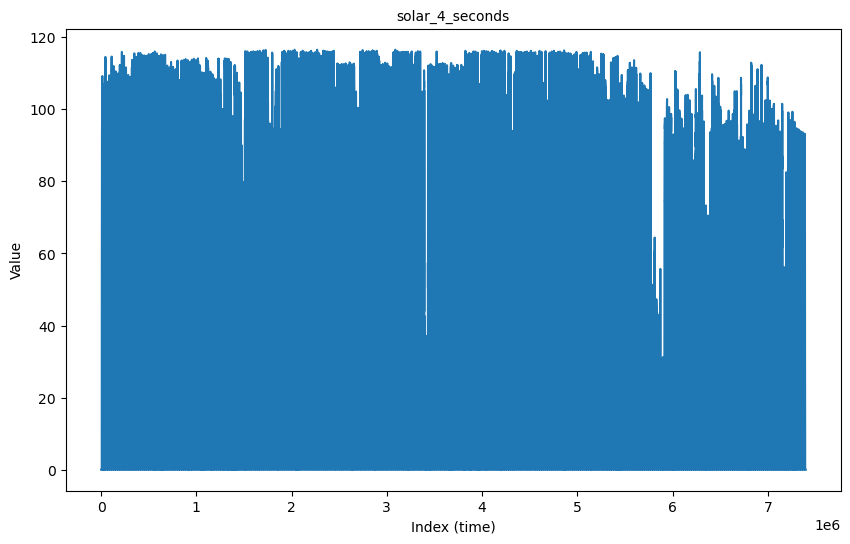

In [24]:
mplots.plot_with_dots(
    time_series = ts, 
    title = config.alias, 
    fontsize = 10, 
    dots = False, 
    sequence_flag = False
)

### Build the MatrixProfile object

In [25]:
solar_mp = mplots.MatrixProfile(
    data      = ts, 
    data_b    = ts, 
    self_join = False
) #Some error in naive, use it like this

### Choose window length

In [26]:
solar_mp.subsequence_len

0

### Compute the Matrix Profile

In [27]:
solar_mp.compute(
    d               = mplots.z_normalized_euclidean_distance, 
    method          = 'stump', #'scamp', # Scamp devuelve todo a 0 en el de insectos. ¿Algún problema con la GPU?
    downsample_flag = True,
    min_points      = 10000,
    max_points      = 20000,
    verbose         = 3
)

[ Downsample | Position ] Before | Pos (0, -1)
[ Downsample | Position ] After | Pos (0, 7397222)
[ Downsample | downsample_propose_crop ] Max points: 20000
[ Downsample | downsample_propose_crop ] Min points: 10000
[ Downsample | downsample_propose_crop ] N timestamps 7397222
[ Downsample | downsample_propose_crop ] PAA factor: 369
[ Downsample | downsample_propose_crop ] allow_crop: True
[ Downsample | downsample_propose_crop ] N: 7397222
[ Downsample | downsample_propose_crop ] potential_segments: 20046
Verbose: 1
Downsample Propose Crop | Prev N: 7397222
Verbose:  0
Verbose:  0
Verbose:  0
Downsample Propose Crop | Post N: 7397220 | Largest Divisor: 19885
[ Downsample | downsample_propose_crop ] Allow crop => change n_timestamp | Before 7397222
[ Downsample | downsample_propose_crop ] Allow crop => change n_timestamp | After 7397222
[ Downsample | downsample_propose_crop --> ] | N segments: 19885 | Data ~ (7397220,)
[ Downsample | downsample_propose_crop --> ] | N = 7397220 | n_tim

array([0.1013954992594152, 0.10895338427950813, 0.11356605116805193, ...,
       0.08402120390155374, 0.08312025087716812, 0.08372244221901433],
      dtype=object)

In [28]:
len(solar_mp.index)

19859

In [29]:
len (solar_mp.distances)

19859

### Visualization of the matrix profile

With the interactive plot we can visually check the motif and anomaly indexes.
The previous and next buttons can be used for going subsequence by subsequence whereas the Motif and Discord buttons show the associated subsequences.

In [30]:
solar_mp.subsequence_len

28

Current index: 0
--> Ordering distances
--> Setup Y index
y_start: 0.0 | y_stop 4.669912140068263 | y_step 1.1674780350170657
--> Setup X index
x_start: 0 | y_stop 19859 | x_step 4964.75


Before: Pos 0 Add 0
Plot Interactive | After: Pos 0 Selected index 10524
Plot Interactive | Distances:  [0.1013954992594152 0.10895338427950813 0.11356605116805193 ...
 0.08402120390155374 0.08312025087716812 0.08372244221901433]
Plot Interactive | Window [5524, 15524]


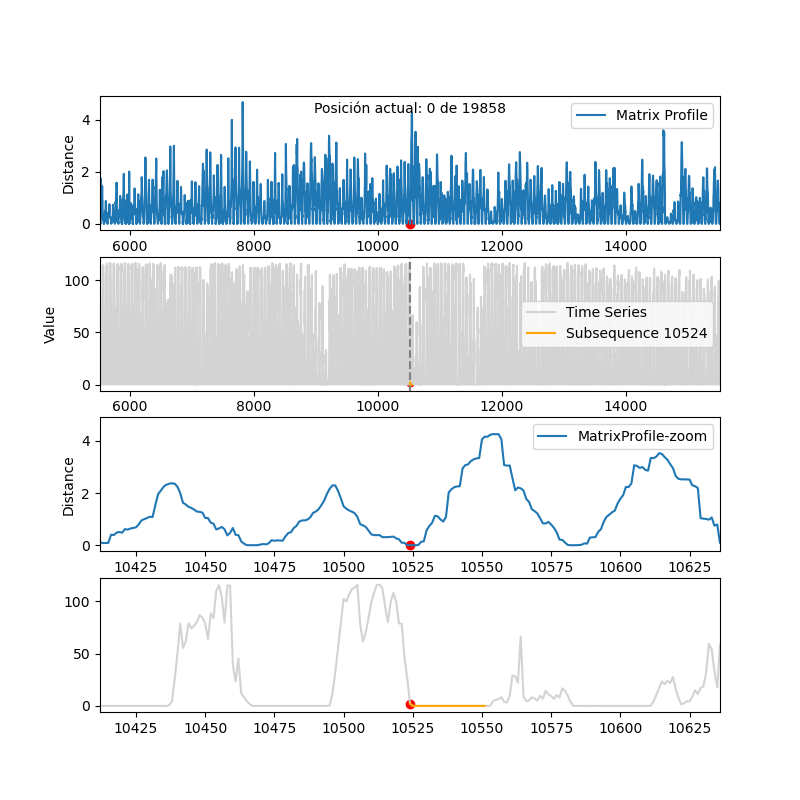

In [31]:
%matplotlib widget
solar_mp.plot_interactive(
    figsize = (8,8),
    verbose = 2
)

### Direct computation & related metadata

#### Motif

In [32]:
solar_mp.get_motif_idx(verbose = 2)

motif id 10524 index ~  19859


(10524, 10466, 10466, 10582)

In [33]:
print(solar_mp.motif_idx)
print(solar_mp.motif_nearest_neighbor_idx)
print(solar_mp.motif_nearest_neighbor_idx_left)
print(solar_mp.motif_nearest_neighbor_idx_right)


10524
10466
10466
10582


#### Discord/Anomaly

In [34]:
solar_mp.get_anomaly_idx(verbose = 2)

motif id 7825 index ~  19859
Nearest  4979
Nearest left  4979
Nearest right  13824


(7825, 4979, 4979, 13824)

In [35]:
print(solar_mp.discord_idx)
print(solar_mp.discord_nearest_neighbor_idx)
print(solar_mp.discord_nearest_neighbor_idx_left)
print(solar_mp.discord_nearest_neighbor_idx_right)

7825
4979
4979
13824


## Check the MPlot

### Build the MatrixProfilePlot object

In [36]:
solar_mplot = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = solar_mp.subsequence_len,
    self_join       = False
)

In [37]:
#| hide
print("MP_AB self_join", solar_mplot.MP_AB.self_join)
print(f"DM_AB ~ {solar_mplot.DM_AB.shape}")
print("MP_AB method:", solar_mplot.MP_AB.method)
print("DM_AB method:", solar_mplot.DM_AB.method)

MP_AB self_join True
DM_AB ~ (0, 0)
MP_AB method: naive
DM_AB method: naive


### Compute the Similarity Matrix

In [38]:
solar_mplot.subsequence_len

28

In [39]:
# z-normalized euclidean distance
from scipy.stats import zscore
from scipy.spatial.distance import euclidean
def distance(u,v):
    return euclidean(zscore(v), zscore(u))

In [40]:
solar_mplot.compute(
    mp_method           = 'stump', 
    dm_method           = 'stump',
    #dm_method          = 'scamp',
    d                   = distance,
    verbose             = 1,
    debug               = False,
    time_flag           = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    min_points          = 10000,
    max_points          = 20000,
    #nlens              = 5,
    provide_len         = False,
    subsequence_len     = solar_mplot.subsequence_len, #Revisar por qué no pilla bien coger el subsequence_len de los atributos
    downsample_flag     = True,
    min_lag             = 8,
    threads             = 1,
    gpus                = [1]
)

MatrixProfilePlot | Distance: distance
MatrixProfilePlot | Compute | Range [0:7397222, 0:7397222]
[ MPlot | Compute ] | -->  Downsample TA
Verbose:  -2
Verbose:  -2
Verbose:  -2
[ MPlot | Compute ] | Downsample TA ~ 19886 ---> 
[ MPlot | Compute ] | -->  Downsample TB
[ MPlot | Compute ] |  --> Downsample TB 
Verbose:  -2
Verbose:  -2
Verbose:  -2
[ MPlot | Compute ] | Downsample TB_paa ~ 19886 ---> 
[ MPlot | Compute ] |Downsample -->
MPlot | Compute | --> Ensure parameters 
MPlot | Compute | --> provide_len 
[ MPlot | Compute ] | Ensure Parameters TB_paa ~ 19886 ---> 
MatrixProfilePlot | Compute | Final Range [0:19886, 0:19886]
MPlot | Compute | --> Instantiate DM & MP | TA ~ 19886 | TB ~ 19886
MPlot | Compute | ... Checking inicializations ...
MP_AB self_join False
DM_AB self_join False
DM_AB ~ (0, 0)
MP_AB method: naive
DM_AB method: naive
MP_AB data_b ~ 19886
DM_AB data_b ~ 19886
MPlot | Compute | ... Checking inicializations ...
MPlot | Compute | --> Compute MP
MPlot | Compute | 

### Check the obtained values

In [41]:
print(solar_mplot.subsequence_len)

28


In [42]:
n_a = len(solar_mplot.data)
n_b = len(solar_mplot.data_b)
print("-- DM Expected dimensions -- ")
print("Rows: ", n_b - solar_mplot.subsequence_len + 1)
print("Columns: ", n_a - solar_mplot.subsequence_len + 1)
print(f"-- Obtained shape when computing using  {solar_mplot.DM_AB.method} --")
print(solar_mplot.DM_AB.shape)
print(f"-- MP dimension using {solar_mplot.MP_AB.method}")
print(len(solar_mplot.MP_AB.distances))
print("-- DM Values --")
print(solar_mplot.DM_AB.distances)
print("-- MP values --")
print(solar_mplot.MP_AB.distances)

-- DM Expected dimensions -- 
Rows:  7397195
Columns:  7397195
-- Obtained shape when computing using  stump --
(19859, 19859)
-- MP dimension using stump
19859
-- DM Values --
[[  0.          42.8333623   82.53222905 ... 405.07676074 394.47204916
  383.54576985]
 [         inf          inf          inf ... 417.02941617 406.73646188
  396.14859513]
 [         inf          inf          inf ... 429.02673208 419.02903073
  408.75969541]
 ...
 [405.07676074 417.02941617 429.02673208 ...          inf          inf
           inf]
 [394.47204916 406.73646188 419.02903073 ...          inf          inf
           inf]
 [383.54576985 396.14859513 408.75969541 ...          inf          inf
           inf]]
-- MP values --
[9.665514320049034 10.146342635403897 10.624065553027014 ...
 5.165474713602052 5.008330046385866 5.005683266085394]


### Visualize the plot

#### Setting up a threshold

It has been checked that, at least for insect raxodus, STUMP separates more the distances than SCAMP, so the proposed thresholds show similar plots for the specific case.

In [43]:
# Threshold per method
threshold_scamp = 10
threshold_stump = 7.5
# Select the threshold for the method used for the computation
threshold = threshold_stump if solar_mplot.DM_AB.method == 'stump' else threshold_scamp

#### Visualizing the MPlot in gray scale

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;TODO: check, the gray_color flag is in the opposite way... 
    </div>
</div>

In [44]:
solar_mplot.subsequence_len

28

Threshold: 7.5 | Mehod: stump


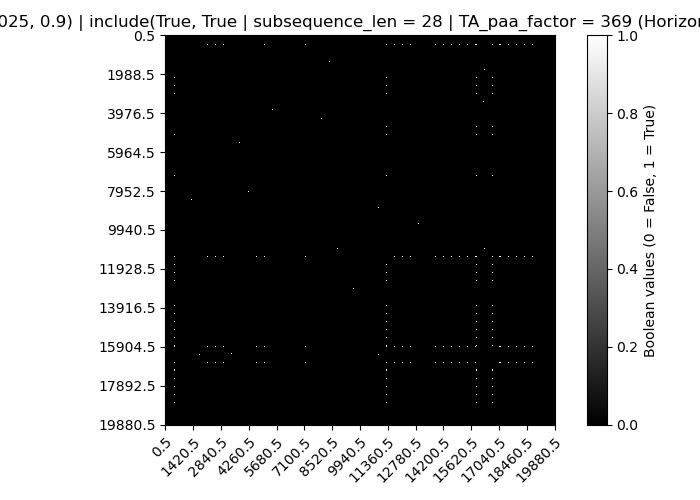

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [50]:
print(f"Threshold: {threshold} | Mehod: {solar_mplot.DM_AB.method}")

solar_mplot.plot(
    ts_name     = 'Variable 0',
    figsize     = (7,5),
    verbose     = 0,
    less_labels = True,
    # debug_flag  = False,
    dm_filter   = mplots.threshold_interval,
    th_min      = 0.025,
    th_max      = 0.9,
    include_min = True,
    include_max = True,
    MPlot_title = 'Variable 0: MPlot | ' + solar_mplot.DM_AB.method,
    plot_mp_flag= False,
    gray_color  = True
)

#### Zoom!

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;Remember that in MPlots zooming in-out is not recommended due to the approximations. Thus. We directly show the specific part 
    </div>
</div>

In [46]:
run.finish

<bound method Run.finish of <wandb.sdk.wandb_run.Run object at 0x7f412d1a8c40>>

In [47]:
if reset_kernel:
    os._exit(00)